# Decision Tree

In [1]:
import os
import numpy as np

In [2]:
from IPython.display import clear_output

In [3]:
from learning_to_style_check.features import tokenize

def tokenize_sample(sample):
    return {
        "code_tokenized": tokenize(sample["code"]),
        "style_context_tokenized": tokenize(sample["style_context"])
    }

In [4]:
def build_bow_feaures(sample, n_grams):
    return {
        "code_bow": count_n_gram_occurences(sample["code_tokenized"], n_grams),
        "style_context_bow": count_n_gram_occurences(sample["style_context_tokenized"], n_grams),
    }

In [5]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, auc):
    plt.plot(fpr, tpr, label=f"auc = {auc}")
    plt.legend(loc=4)
    plt.show()

In [6]:
import evaluate

from learning_to_style_check.train.metrics import calc_roc_auc, calc_roc_curve, calc_confusion_matrix, \
    calc_brier_score_loss, calc_balanced_accuracy


def evaluate_predictions(references, prediction_scores):
    metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
    custom_metrics = [calc_roc_auc, calc_roc_curve, calc_confusion_matrix, calc_brier_score_loss,
                      calc_balanced_accuracy]

    predictions = np.round(prediction_scores)

    eval_dict = {
        **metrics.compute(predictions=predictions,
                          references=references)
    }

    for metric in custom_metrics:
        eval_dict.update(metric(references=references,
                                predictions=predictions,
                                predictions_scores=prediction_scores))

    return eval_dict

/homes/theptner/learning-to-style-check/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import pickle

from collections import defaultdict

def get_all_n_grams(path, occurences=None, occurences_type=None):
    with open(path, "rb") as f:
        n_grams_per_dataset = pickle.load(f)

    n_grams_with_counts = [defaultdict(int) for _ in range(len(n_grams_per_dataset[0][0]))]
    
    for dataset_n_grams in n_grams_per_dataset:
        for n_grams_info in dataset_n_grams:
            for k, v in n_grams_info[0].items():
                n_grams_with_counts[0][k] += v
            for k, v in n_grams_info[1].items():
                n_grams_with_counts[1][k] += v
            for k, v in n_grams_info[2].items():
                n_grams_with_counts[2][k] += v

    all_n_grams = []
    for n, n_grams_info in enumerate(n_grams_with_counts):
        if occurences is not None and occurences_type == "min":
            filtered_n_grams = [n_gram if isinstance(n_gram, tuple) else (n_gram,) for n_gram, count in filter(lambda v: v[1] >= occurences, n_grams_info.items())]
            all_n_grams.append((f"{n+1}-gram min {occurences}" , filtered_n_grams))
        elif occurences is not None and occurences_type == "max":
            filtered_n_grams = [n_gram if isinstance(n_gram, tuple) else (n_gram,) for n_gram, count in filter(lambda v: v[1] < occurences, n_grams_info.items())]
            all_n_grams.append((f"{n+1}-gram max {occurences}" , filtered_n_grams))
        else:
            all_n_grams.append((f"{n+1}-gram" , [k if isinstance(k, tuple) else (k,) for k in n_grams_info.keys()]))

    return all_n_grams

In [8]:
from collections import defaultdict, deque
from itertools import islice

def count_n_gram_occurences(tokens, n_grams, max_scale=True):
    n_grams_ranges = set([len(gram) for gram in n_grams])
    counts = defaultdict(int)

    # only save max n items, where n is the max of n_gram len
    buffer = deque(maxlen=max(n_grams_ranges))

    # count all n-grams with a sliding windows
    for i, t in enumerate(tokens):
        buffer.append(t)
        for n in n_grams_ranges:
            n_gram = list(islice(buffer, 0, n))
            if len(n_gram) == n:
                counts[tuple(n_gram)] += 1
    
    bow = np.array([counts.get(gram, 0) for gram in n_grams])
    if max_scale:
        return bow / np.max(bow)
    else:
        return bow

In [9]:
from itertools import product, repeat
from datasets import load_dataset
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool

def preprocess_dataset(name, n_grams):
    dataset = load_dataset(name)
    dataset = dataset.map(tokenize_sample, num_proc=os.cpu_count())
    dataset = dataset.map(build_bow_feaures, fn_kwargs={"n_grams": n_grams}, num_proc=os.cpu_count())
    return dataset.with_format("np")

def get_stacked_train_test_dataset(dataset):
    X_train = np.hstack((dataset["train"]["code_bow"], dataset["train"]["style_context_bow"]))
    y_train = dataset["train"]["label"]
    X_test = np.hstack((dataset["test"]["code_bow"], dataset["test"]["style_context_bow"]))
    y_test  = dataset["test"]["label"]

    return X_train, y_train, X_test, y_test

def train_and_get_f1_score(args):
    params, X_train, y_train, X_test, y_test = args
    clf = DecisionTreeClassifier(**params, random_state=42)
    clf.fit(X_train, y_train)

    return f1_score(y_test, clf.predict(X_test)), clf

def param_grid(params):
    for param_products in product(*params.values()):
        yield dict(zip(params.keys(), param_products))

def find_best_model_params(dataset, params, X_train, y_train, X_test, y_test):
    with ThreadPool() as p:
        worker_args = zip(param_grid(params), repeat(X_train), repeat(y_train), repeat(X_test), repeat(y_test))
        scores_and_models = list(p.imap(train_and_get_f1_score, worker_args))

    best_score = 0
    best_params = None
    best_model = None
    for (score, model), p in zip(scores_and_models, param_grid(params)):
        if best_score < score:
            best_score = score
            best_params = p
            best_model = model
    
    return best_model, best_params

In [10]:
def eval_clf(clf, X_test, y_test):
    y_pred = clf.predict_proba(X_test)[:,1]
    evals = evaluate_predictions(y_test, y_pred)
    return evals

In [11]:
# all_ngrams = get_all_n_grams("test_data/ngrams_per_dataset.pkl")

In [12]:
min_all_ngrams = get_all_n_grams("test_data/ngrams_per_dataset.pkl", occurences=182_191, occurences_type="min")

In [13]:
# max_all_ngrams = get_all_n_grams("test_data/ngrams_per_dataset.pkl", occurences=182_191, occurences_type="max")

In [14]:
params = {"max_depth": [None] + list(range(50, 501, 50))}
params

{'max_depth': [None, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}

### 1-grams

In [15]:
n_grams = min_all_ngrams[0][1]
n_grams

[('\r',),
 ('\n',),
 ('def',),
 ('<SPACE1>',),
 ('<TAB4>',),
 ('<TAB2>',),
 ('<SINGLE_LEADING_UNDERSCORE_NAME>',),
 ('<LETTER_LOW>',),
 ('<SPACE4>',),
 ('(',),
 ('<SPACE2>',),
 (':',),
 ('<LOWERCASE>',),
 (')',),
 ('<TAB1>',),
 ('->',),
 ('<UPPER_CAMEL_CASE>',),
 ('=',),
 ('[',),
 (']',),
 ('{',),
 ("'''",),
 ('<STRING>',),
 (',',),
 ('}',),
 ('for',),
 ('in',),
 ('if',),
 ('<SNAKE_CASE>',),
 ('.',),
 ('elif',),
 ('and',),
 ('==',),
 ('<INT>',),
 ('or',),
 ('>',),
 ('!=',),
 ('return',),
 ('False',),
 ('else',),
 ('<MAGIC_NAME>',),
 ('"',),
 ('<UPPER_CAMEL_CASE2>',),
 ('<DOUBLE_TRAILING_UNDERSCORE_NAME>',),
 ('assert',),
 ('<COMMENT>',),
 ('*',),
 ('+',),
 ('<SCREAMING_SNAKE_CASE>',),
 ('-',),
 ('import',),
 ('from',),
 ('<UNDEF_NAME_PATTERN>',),
 ('raise',),
 ('F',),
 ('"""',),
 ('try',),
 ('not',),
 ('except',),
 ('pass',),
 ('True',),
 ('+=',),
 ('/',),
 ('f',),
 ('@',),
 ('None',),
 ('is',),
 ('<EXP_LOW>',),
 ('as',),
 ('<FLOAT>',),
 ('<NUMBER_UNDERSCORE>',),
 ('class',),
 ('<SINGL

#### Random 500 dataset

In [16]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': None}


(53, 15287)

In [17]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.6342423490194687,
 'f1': 0.6071455778167136,
 'precision': 0.6557511930228731,
 'recall': 0.5652482269503546,
 'roc_auc': 0.6342447957930721,
 'roc_curve': [[0.0, 0.2967586353642102, 1.0],
  [0.0, 0.5652482269503546, 1.0],
  [inf, 1.0, 0.0]],
 'confusion_matrix': [[9915, 4184], [6130, 7970]],
 'brier_score_loss': 0.3657576509805312,
 'balanced_accuracy': 0.6342447957930721}

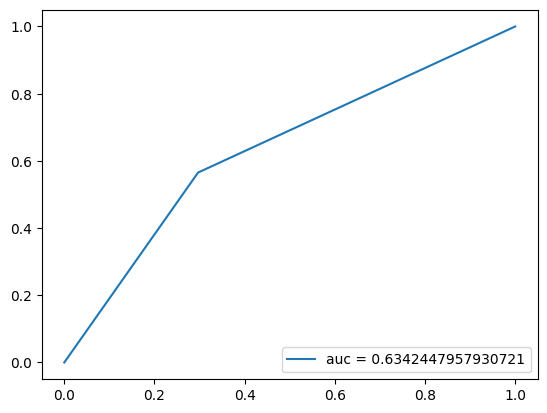

In [18]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 500 dataset

In [19]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': None}


(49, 26434)

In [20]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5126095129996807,
 'f1': 0.4901109503135553,
 'precision': 0.5139699587516539,
 'recall': 0.4683687943262411,
 'roc_auc': 0.5126317526985128,
 'roc_curve': [[0.0, 0.44312779394025403, 0.44561129638827784, 1.0],
  [0.0, 0.4683687943262411, 0.47078014184397166, 1.0],
  [inf, 1.0, 0.5, 0.0]],
 'confusion_matrix': [[7848, 6245], [7496, 6604]],
 'brier_score_loss': 0.48679636789273933,
 'balanced_accuracy': 0.5126205001929935}

In [21]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 500 dataset

In [22]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': None}


(44, 21824)

In [23]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5504717315740938,
 'f1': 0.5437396500827993,
 'precision': 0.5541125541125541,
 'recall': 0.5337479680542795,
 'roc_auc': 0.5505612456311925,
 'roc_curve': [[0.0, 0.4326806692773229, 0.433250266998932, 1.0],
  [0.0, 0.5337479680542795, 0.5343133790373878, 1.0],
  [inf, 1.0, 0.5, 0.0]],
 'confusion_matrix': [[7968, 6077], [6597, 7552]],
 'brier_score_loss': 0.44938639426828403,
 'balanced_accuracy': 0.5505336493884783}

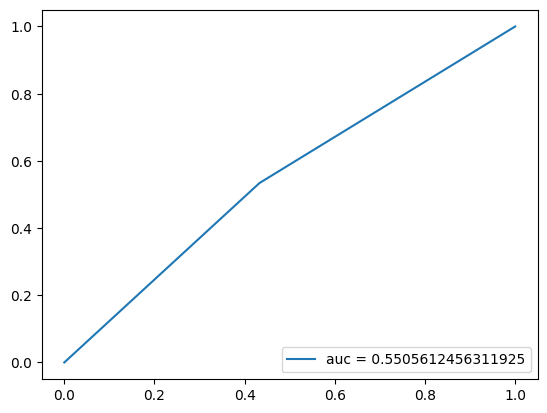

In [24]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Random 1k dataset

In [25]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 30666)

In [26]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.6458510638297872,
 'f1': 0.6270585160013443,
 'precision': 0.6621973341746195,
 'recall': 0.5954609929078014,
 'roc_auc': 0.6455639228409035,
 'roc_curve': [[0.0,
   0.30347517730496454,
   0.30368794326241133,
   0.30375886524822693,
   1.0],
  [0.0, 0.5930141843971631, 0.5949645390070922, 0.5954609929078014, 1.0],
  [inf, 1.0, 0.9978880675818373, 0.9722222222222222, 0.0]],
 'confusion_matrix': [[19634, 8566], [11408, 16792]],
 'brier_score_loss': 0.35414674048678463,
 'balanced_accuracy': 0.6458510638297872}

In [27]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 1k dataset

In [28]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 52167)

In [29]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5157640883781963,
 'f1': 0.5020241438418616,
 'precision': 0.5167429987236279,
 'recall': 0.48812056737588655,
 'roc_auc': 0.5157264384505128,
 'roc_curve': [[0.0,
   0.45651557068879905,
   0.45655103922820456,
   0.4565865077676101,
   0.4593530538412428,
   1.0],
  [0.0,
   0.4880141843971631,
   0.48812056737588655,
   0.48812056737588655,
   0.4906028368794326,
   1.0],
  [inf, 1.0, 0.9444444444444444, 0.6666666666666666, 0.5, 0.0]],
 'confusion_matrix': [[15321, 12873], [14435, 13765]],
 'brier_score_loss': 0.48363914031656463,
 'balanced_accuracy': 0.5157670298041382}

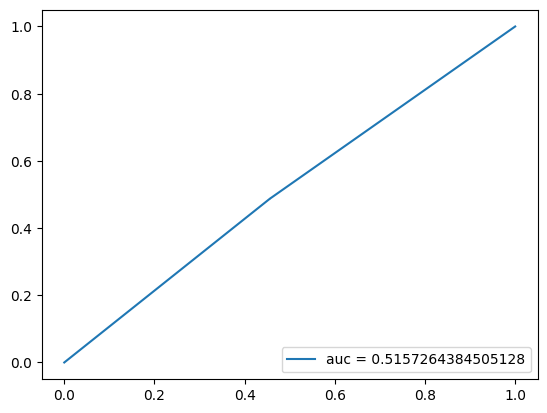

In [30]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 1k dataset

In [31]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 42856)

In [32]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5608575380359613,
 'f1': 0.5555056986448891,
 'precision': 0.5605462382729018,
 'recall': 0.5505550021346236,
 'roc_auc': 0.5609007969442538,
 'roc_curve': [[0.0,
   0.4286926394682882,
   0.42890475853779253,
   0.4295057625680549,
   1.0],
  [0.0, 0.5504126938949765, 0.5505550021346236, 0.5511953892130355, 1.0],
  [inf, 1.0, 0.9629629629629629, 0.5, 0.0]],
 'confusion_matrix': [[16154, 12132], [12633, 15475]],
 'brier_score_loss': 0.43897079960592755,
 'balanced_accuracy': 0.5608251217984155}

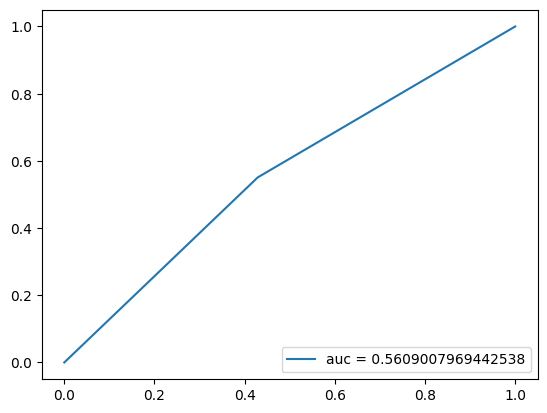

In [33]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

### 2-grams

In [34]:
n_grams = min_all_ngrams[1][1]
n_grams

[('\r', '\n'),
 ('\n', '\r'),
 ('\n', 'def'),
 ('def', '<SPACE1>'),
 ('<SPACE1>', '<TAB4>'),
 ('<TAB4>', '<TAB2>'),
 ('<TAB2>', '<SINGLE_LEADING_UNDERSCORE_NAME>'),
 ('<SINGLE_LEADING_UNDERSCORE_NAME>', '<LETTER_LOW>'),
 ('<LETTER_LOW>', '<SPACE4>'),
 ('<SPACE4>', '('),
 ('(', '<SPACE4>'),
 ('<SPACE4>', '<SPACE2>'),
 ('<SPACE2>', '<LETTER_LOW>'),
 ('<LETTER_LOW>', '<SPACE1>'),
 ('<SPACE1>', ':'),
 (':', '<LOWERCASE>'),
 ('<LOWERCASE>', '<SPACE1>'),
 ('<SPACE1>', ')'),
 (')', '<TAB4>'),
 ('<TAB2>', '<TAB1>'),
 ('<TAB1>', '->'),
 ('->', '<TAB2>'),
 ('<TAB1>', '<UPPER_CAMEL_CASE>'),
 ('<UPPER_CAMEL_CASE>', ':'),
 (':', '\r'),
 ('\n', '<SPACE1>'),
 ('<SPACE1>', '<LETTER_LOW>'),
 ('<LETTER_LOW>', '<TAB2>'),
 ('<TAB2>', '<SPACE2>'),
 ('<SPACE2>', '='),
 ('=', '<SPACE4>'),
 ('<SPACE2>', '['),
 ('[', ']'),
 (']', '\r'),
 ('<SPACE2>', '<LOWERCASE>'),
 ('<LOWERCASE>', '('),
 ('{', "'''"),
 ("'''", '<STRING>'),
 ('<STRING>', "'''"),
 ("'''", ','),
 (',', '<SPACE1>'),
 ('<SPACE1>', "'''"),
 (')', 

#### Random 500 dataset

In [35]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 7502)

In [36]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.6927195999858151,
 'f1': 0.6561371482995357,
 'precision': 0.7448418776466348,
 'recall': 0.5863120567375887,
 'roc_auc': 0.6878001709290786,
 'roc_curve': [[0.0,
   0.17192708702744874,
   0.1722107950918505,
   0.17277821122065395,
   0.1750478757358678,
   0.1763245620256756,
   0.17738846726718208,
   0.17802681041208596,
   0.17901978863749202,
   0.18036740194340023,
   0.1834881906518193,
   0.18582878218313356,
   0.18646712532803744,
   0.1900844031491595,
   0.1919994325838712,
   0.1954748563727924,
   0.2005106745159231,
   0.200652528548124,
   0.20079438258032484,
   0.2008653095964253,
   0.2008653095964253,
   1.0],
  [0.0,
   0.4512765957446809,
   0.4549645390070922,
   0.45617021276595743,
   0.4672340425531915,
   0.4800709219858156,
   0.48340425531914893,
   0.48652482269503544,
   0.4875886524822695,
   0.49347517730496454,
   0.498936170212766,
   0.5112056737588653,
   0.5178014184397163,
   0.5458865248226951,
   0.5477304964539007,
   0.5666666

In [37]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 500 dataset

In [38]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 20434)

In [39]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5200936402653141,
 'f1': 0.4762715800882558,
 'precision': 0.52428839270496,
 'recall': 0.43631205673758866,
 'roc_auc': 0.5205003011907224,
 'roc_curve': [[0.0,
   0.343858653232101,
   0.34428439650890513,
   0.3447101397857092,
   0.34499396863691195,
   0.3451358830625133,
   0.345419711913716,
   0.3460583268289222,
   0.3460583268289222,
   0.3464131128929256,
   0.3466969417441283,
   0.34712268502093235,
   0.34832895763854393,
   0.3486127864897467,
   0.34868374370254734,
   0.34882565812814875,
   0.34996097353295963,
   0.35024480238416233,
   0.3503867168097637,
   0.35102533172496986,
   0.3510962889377705,
   0.3514510750017739,
   0.351663946640176,
   0.3517349038529767,
   0.3518058610657773,
   0.3520187327041794,
   0.3520896899169801,
   0.35216064712978074,
   0.3533669197473923,
   0.3533669197473923,
   0.353437876960193,
   0.3546441495778046,
   0.3553537217058114,
   0.3556375505570141,
   0.3557794649826155,
   0.35670190874902435,
   0.357198

In [40]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 500 dataset

In [41]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 15843)

In [42]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5914733631269065,
 'f1': 0.5793587027974582,
 'precision': 0.5994105644978462,
 'recall': 0.560604989751926,
 'roc_auc': 0.5902321755332386,
 'roc_curve': [[0.0,
   0.3537201851192595,
   0.35500177999288,
   0.35521537913848344,
   0.3560697757208971,
   0.35792096831612674,
   0.3589889640441438,
   0.3601993592025632,
   0.3604129583481666,
   0.36048415806336775,
   0.36105375578497684,
   0.3626201495194019,
   0.36333214667141334,
   0.36333214667141334,
   0.36375934496262013,
   0.3644001423994304,
   0.36447134211463156,
   0.36475614097543607,
   0.36553933784264864,
   0.3659665361338555,
   0.36760412958348165,
   0.3678177287290851,
   0.36810252758988965,
   0.36810252758988965,
   0.3686009255962976,
   0.3686009255962976,
   0.36938412246351016,
   0.3703809184763261,
   0.37066571733713066,
   0.37066571733713066,
   0.3707369170523318,
   0.3707369170523318,
   0.3710217159131364,
   0.3713065147739409,
   0.3714489142043432,
   0.3714489142043432,
   0

In [43]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Random 1k dataset

In [44]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 18408)

In [45]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.6675886524822695,
 'f1': 0.6412003368292123,
 'precision': 0.6964909363046732,
 'recall': 0.5940425531914894,
 'roc_auc': 0.6578769321211206,
 'roc_curve': [[0.0,
   0.22177304964539007,
   0.22273049645390072,
   0.22319148936170213,
   0.22478723404255319,
   0.2251418439716312,
   0.225177304964539,
   0.2255673758865248,
   0.22592198581560283,
   0.22620567375886524,
   0.22645390070921986,
   0.2274468085106383,
   0.2275177304964539,
   0.23060283687943262,
   0.23099290780141843,
   0.23177304964539008,
   0.2326241134751773,
   0.2327304964539007,
   0.23301418439716312,
   0.23358156028368796,
   0.23429078014184399,
   0.23436170212765958,
   0.2349290780141844,
   0.23546099290780143,
   0.23592198581560284,
   0.23627659574468085,
   0.23634751773049645,
   0.2372340425531915,
   0.2375886524822695,
   0.24007092198581562,
   0.24202127659574468,
   0.2422695035460993,
   0.24262411347517732,
   0.24297872340425533,
   0.24312056737588653,
   0.2433687943262

In [46]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 1k dataset

In [47]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 41571)

In [48]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5204986346065185,
 'f1': 0.5016494351375759,
 'precision': 0.5222362917769847,
 'recall': 0.4826241134751773,
 'roc_auc': 0.5203089542465904,
 'roc_curve': [[0.0,
   0.39508406043839117,
   0.3952968716748244,
   0.39554515145066327,
   0.3962899907781798,
   0.3967156132510463,
   0.3967510817904519,
   0.3971767042633184,
   0.3972831098815351,
   0.39735404696034615,
   0.3979215435908349,
   0.3982762289848904,
   0.39845357168191814,
   0.3985954458395403,
   0.3986309143789459,
   0.39898559977300135,
   0.39951762786408457,
   0.4002269986521955,
   0.4007235582038732,
   0.4007235582038732,
   0.4011491806767397,
   0.4017166773072285,
   0.4018230829254451,
   0.4021068312406895,
   0.40221323685890614,
   0.4023196424771228,
   0.40242604809533944,
   0.40253245371355606,
   0.40288713910761154,
   0.40320635596226145,
   0.40320635596226145,
   0.40331276158047813,
   0.4033836986592892,
   0.40395119528977796,
   0.40395119528977796,
   0.4041285379868057,
  

In [49]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 1k dataset

In [50]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 33867)

In [51]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5679327588041281,
 'f1': 0.5561263526068423,
 'precision': 0.5698499216008363,
 'recall': 0.5430482424932404,
 'roc_auc': 0.5669010449397306,
 'roc_curve': [[0.0,
   0.38407692851587355,
   0.3842890475853779,
   0.384925404793891,
   0.38517287704164604,
   0.3856678215371562,
   0.3858092342501591,
   0.3860567064979142,
   0.3862688255674185,
   0.3865516509934243,
   0.3865516509934243,
   0.3866930637064272,
   0.3867991232411794,
   0.38789507176695187,
   0.38800113130170405,
   0.38934455207523155,
   0.39005161564024604,
   0.39044050060100405,
   0.39075867920526053,
   0.3911122109877678,
   0.39118291734426924,
   0.3916778618397794,
   0.3921020999787881,
   0.3925616912960475,
   0.3926677508307997,
   0.3939758184260765,
   0.39432935020858373,
   0.3948242947040939,
   0.39521317966485187,
   0.39521317966485187,
   0.3967687195078838,
   0.3972283108251432,
   0.39761719578590116,
   0.39835961252916635,
   0.3989959697376794,
   0.3992434419854345,
   0

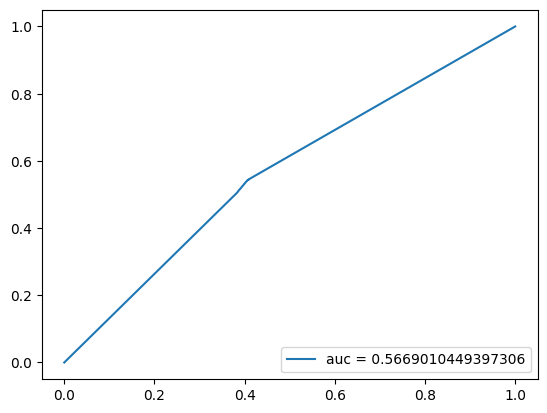

In [52]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

### 3-grams

In [53]:
n_grams = min_all_ngrams[2][1]
n_grams

[('\r', '\n', '\r'),
 ('\n', '\r', '\n'),
 ('\r', '\n', 'def'),
 ('\n', 'def', '<SPACE1>'),
 ('def', '<SPACE1>', '<TAB4>'),
 ('<SPACE1>', '<TAB4>', '<TAB2>'),
 ('<TAB4>', '<TAB2>', '<SINGLE_LEADING_UNDERSCORE_NAME>'),
 ('<SINGLE_LEADING_UNDERSCORE_NAME>', '<LETTER_LOW>', '<SPACE4>'),
 ('(', '<SPACE4>', '<SPACE2>'),
 ('<SPACE4>', '<SPACE2>', '<LETTER_LOW>'),
 ('<LOWERCASE>', '<SPACE1>', ')'),
 ('<SPACE1>', ')', '<TAB4>'),
 (')', '<TAB4>', '<TAB2>'),
 ('<TAB4>', '<TAB2>', '<TAB1>'),
 ('<TAB2>', '<TAB1>', '->'),
 ('<TAB2>', '<TAB1>', '<UPPER_CAMEL_CASE>'),
 ('<UPPER_CAMEL_CASE>', ':', '\r'),
 (':', '\r', '\n'),
 ('\r', '\n', '<SPACE1>'),
 ('<SPACE2>', '=', '<SPACE4>'),
 ('=', '<SPACE4>', '<SPACE2>'),
 ('[', ']', '\r'),
 (']', '\r', '\n'),
 ('<SPACE4>', '<SPACE2>', '<LOWERCASE>'),
 ('<SPACE2>', '<LOWERCASE>', '('),
 ('{', "'''", '<STRING>'),
 ("'''", '<STRING>', "'''"),
 ('<STRING>', "'''", ','),
 ("'''", ',', '<SPACE1>'),
 (',', '<SPACE1>', "'''"),
 ('<SPACE1>', "'''", '<STRING>'),
 ('<SP

#### Random 500 dataset

In [54]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 5498)

In [55]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.7376502712862159,
 'f1': 0.7165517241379311,
 'precision': 0.77925,
 'recall': 0.6631914893617021,
 'roc_auc': 0.7342623690931251,
 'roc_curve': [[0.0,
   0.1120646854386836,
   0.11291580963188878,
   0.11348322576069225,
   0.11419249592169657,
   0.11433434995389744,
   0.11674586850131215,
   0.11745513866231648,
   0.11951202212922903,
   0.12000851124193206,
   0.12178168664444287,
   0.1220653947088446,
   0.12298744591815022,
   0.1255408184977658,
   0.12781048301297965,
   0.12802326406128095,
   0.12851975317398398,
   0.13674728704163416,
   0.13696006808993547,
   0.13830768139584368,
   0.14242144832966877,
   0.14362720760337613,
   0.14774097453720123,
   0.14788282856940207,
   0.15064898219731895,
   0.15306050074473368,
   0.15731612171075962,
   0.15752890275906092,
   0.15802539187176395,
   0.15994042130647565,
   0.16752961202922192,
   0.18214057734591105,
   0.18235335839421235,
   0.18306262855521668,
   0.1861124902475353,
   0.1862543442797361

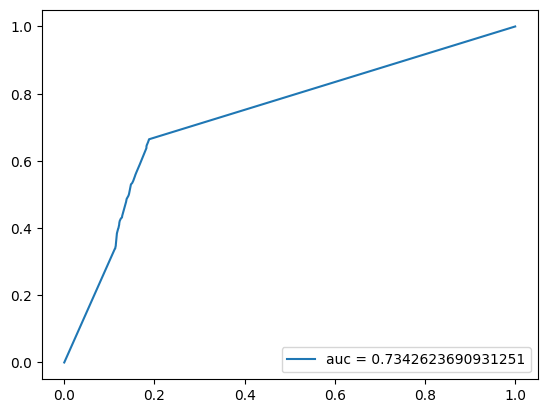

In [56]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 500 dataset

In [57]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 15544)

In [58]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5219380697336218,
 'f1': 0.518917761279269,
 'precision': 0.5223483759701063,
 'recall': 0.515531914893617,
 'roc_auc': 0.523129258376348,
 'roc_curve': [[0.0,
   0.2684311360249769,
   0.268644007663379,
   0.26977932306818986,
   0.2702760235577947,
   0.27063080962179803,
   0.2711984673242035,
   0.27148229617540626,
   0.2715532533882069,
   0.2719080394522103,
   0.27212091109061237,
   0.27233378272901443,
   0.27261761158021713,
   0.27297239764422054,
   0.2730433548570212,
   0.273540055346626,
   0.27403675583623077,
   0.2743205846874335,
   0.27481728517703824,
   0.27488824238983894,
   0.2765202582842546,
   0.276875044348258,
   0.2769460015610587,
   0.2772298304122614,
   0.2775846164762648,
   0.27829418860427163,
   0.2787908890938764,
   0.28077769105229544,
   0.2809905626906975,
   0.28148726318030226,
   0.28148726318030226,
   0.28240970694671114,
   0.28276449301071455,
   0.2832611935003193,
   0.28425459447952883,
   0.285106081033137,
   0.28

In [59]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 500 dataset

In [60]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 12219)

In [61]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.6082145137263247,
 'f1': 0.6189720593308036,
 'precision': 0.6045414729465669,
 'recall': 0.634108417556011,
 'roc_auc': 0.6102502479522911,
 'roc_curve': [[0.0,
   0.26678533285866857,
   0.2673549305802777,
   0.2688501245995016,
   0.2720541117835529,
   0.2733357066571734,
   0.2735493058027768,
   0.2738341046635813,
   0.2739765040939836,
   0.2754004983980064,
   0.2761124955500178,
   0.27725169099323604,
   0.27746529013883947,
   0.27910288358846563,
   0.2797436810252759,
   0.28002847988608043,
   0.28152367390530436,
   0.2819508721965112,
   0.28202207191171236,
   0.28344606621573515,
   0.2841580633677465,
   0.2868636525453898,
   0.2871484514061944,
   0.2877892488430046,
   0.2887860448558206,
   0.2893556425774297,
   0.28949804200783197,
   0.2900676397294411,
   0.29149163403346384,
   0.2922748309006764,
   0.2928444286222855,
   0.2932004271982912,
   0.2933428266286935,
   0.29348522605909577,
   0.2936988252046992,
   0.29419722321110714,
   0.2

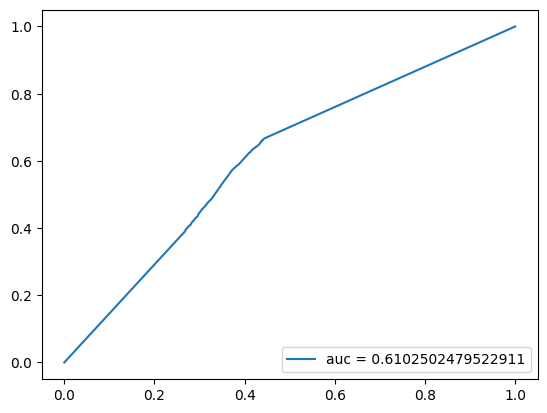

In [62]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Random 1k dataset

In [63]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 9490)

In [64]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.7124468085106384,
 'f1': 0.6997000333296302,
 'precision': 0.7321553127179725,
 'recall': 0.67,
 'roc_auc': 0.7163827209395905,
 'roc_curve': [[0.0,
   0.12195035460992908,
   0.12237588652482269,
   0.12258865248226951,
   0.12329787234042554,
   0.12439716312056738,
   0.12464539007092199,
   0.1249645390070922,
   0.1254964539007092,
   0.12567375886524823,
   0.12595744680851065,
   0.12606382978723404,
   0.12641843971631206,
   0.12652482269503545,
   0.12670212765957448,
   0.1270212765957447,
   0.12808510638297874,
   0.1295744680851064,
   0.12982269503546098,
   0.1321985815602837,
   0.1327304964539007,
   0.1331205673758865,
   0.134645390070922,
   0.1350354609929078,
   0.13801418439716312,
   0.13815602836879431,
   0.13929078014184398,
   0.139822695035461,
   0.14042553191489363,
   0.14042553191489363,
   0.14049645390070922,
   0.14166666666666666,
   0.14202127659574468,
   0.14209219858156028,
   0.14400709219858157,
   0.14546099290780143,
   0.147

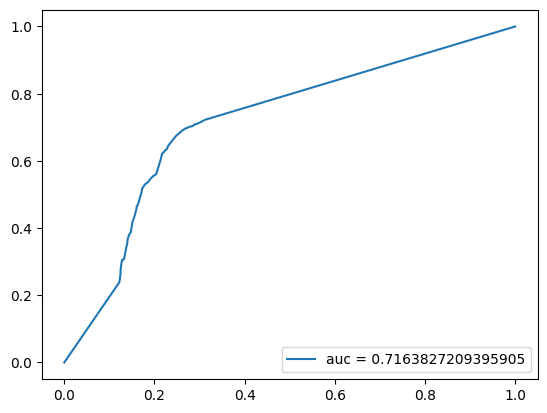

In [65]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 1k dataset

In [66]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 30150)

In [67]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.535517962903855,
 'f1': 0.5466911255710923,
 'precision': 0.5339034613304489,
 'recall': 0.5601063829787234,
 'roc_auc': 0.5336118211107741,
 'roc_curve': [[0.0,
   0.2742427466836916,
   0.2744200893807193,
   0.2744910264595304,
   0.27484571185358586,
   0.2752358657870469,
   0.2757678938781301,
   0.2759097680357523,
   0.27605164219337447,
   0.2767610129814854,
   0.27683195006029654,
   0.27683195006029654,
   0.27729304107256864,
   0.27739944669078526,
   0.27782506916365185,
   0.2780024118606796,
   0.2783925657941406,
   0.2787827197276016,
   0.2787827197276016,
   0.27896006242462934,
   0.2791374051216571,
   0.2796694332127403,
   0.2801305242250124,
   0.28016599276441795,
   0.28083989501312334,
   0.2810172377101511,
   0.28112364332836776,
   0.28112364332836776,
   0.28126551748598994,
   0.2813009860253955,
   0.28172660849826203,
   0.28201035681350645,
   0.28201035681350645,
   0.28218769951053413,
   0.28225863658934525,
   0.28225863658934525,

In [68]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 1k dataset

In [69]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 24411)

In [70]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5891229563428734,
 'f1': 0.5926550990629889,
 'precision': 0.5857862728062554,
 'recall': 0.5996869218727764,
 'roc_auc': 0.592820174496687,
 'roc_curve': [[0.0,
   0.2650427773456834,
   0.2654670154846921,
   0.2661740790497066,
   0.26642155129746165,
   0.2667750830799689,
   0.26712861486247613,
   0.2677649720709892,
   0.2686134483490066,
   0.2689669801315138,
   0.26928515873577036,
   0.2693558650922718,
   0.2702396945485399,
   0.2703104009050414,
   0.27115887718305876,
   0.271512408965566,
   0.2719720002828254,
   0.27229017888708196,
   0.2727497702043414,
   0.2732447146998515,
   0.27373965919536164,
   0.27419925051262106,
   0.2744113695821254,
   0.27501237361238773,
   0.2751184331471399,
   0.27525984586014285,
   0.27543661175139644,
   0.2756840839991515,
   0.2757901435339037,
   0.2757901435339037,
   0.27582549671215445,
   0.27586084989040516,
   0.2761790284946617,
   0.27656791345541964,
   0.2768153857031747,
   0.27731033019868484,
   0.

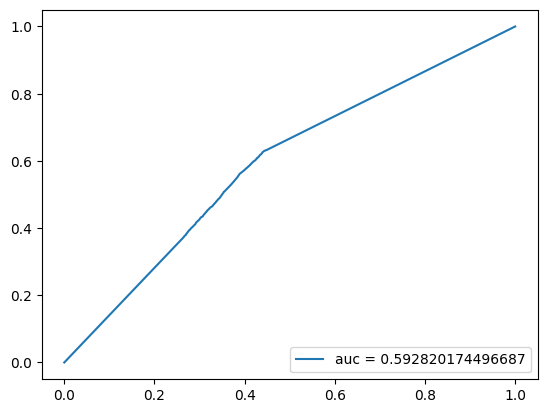

In [71]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

### 1-grams + 2-grams

In [72]:
n_grams = min_all_ngrams[0][1] + min_all_ngrams[1][1]
n_grams

[('\r',),
 ('\n',),
 ('def',),
 ('<SPACE1>',),
 ('<TAB4>',),
 ('<TAB2>',),
 ('<SINGLE_LEADING_UNDERSCORE_NAME>',),
 ('<LETTER_LOW>',),
 ('<SPACE4>',),
 ('(',),
 ('<SPACE2>',),
 (':',),
 ('<LOWERCASE>',),
 (')',),
 ('<TAB1>',),
 ('->',),
 ('<UPPER_CAMEL_CASE>',),
 ('=',),
 ('[',),
 (']',),
 ('{',),
 ("'''",),
 ('<STRING>',),
 (',',),
 ('}',),
 ('for',),
 ('in',),
 ('if',),
 ('<SNAKE_CASE>',),
 ('.',),
 ('elif',),
 ('and',),
 ('==',),
 ('<INT>',),
 ('or',),
 ('>',),
 ('!=',),
 ('return',),
 ('False',),
 ('else',),
 ('<MAGIC_NAME>',),
 ('"',),
 ('<UPPER_CAMEL_CASE2>',),
 ('<DOUBLE_TRAILING_UNDERSCORE_NAME>',),
 ('assert',),
 ('<COMMENT>',),
 ('*',),
 ('+',),
 ('<SCREAMING_SNAKE_CASE>',),
 ('-',),
 ('import',),
 ('from',),
 ('<UNDEF_NAME_PATTERN>',),
 ('raise',),
 ('F',),
 ('"""',),
 ('try',),
 ('not',),
 ('except',),
 ('pass',),
 ('True',),
 ('+=',),
 ('/',),
 ('f',),
 ('@',),
 ('None',),
 ('is',),
 ('<EXP_LOW>',),
 ('as',),
 ('<FLOAT>',),
 ('<NUMBER_UNDERSCORE>',),
 ('class',),
 ('<SINGL

#### Random 500 dataset

In [73]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': None}


(83, 10362)

In [74]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.6277527571899713,
 'f1': 0.5819760264425949,
 'precision': 0.6636091181545727,
 'recall': 0.51822695035461,
 'roc_auc': 0.6277566413593036,
 'roc_curve': [[0.0, 0.26271366763600257, 1.0],
  [0.0, 0.51822695035461, 1.0],
  [inf, 1.0, 0.0]],
 'confusion_matrix': [[10395, 3704], [6793, 7307]],
 'brier_score_loss': 0.37224724281002874,
 'balanced_accuracy': 0.6277566413593036}

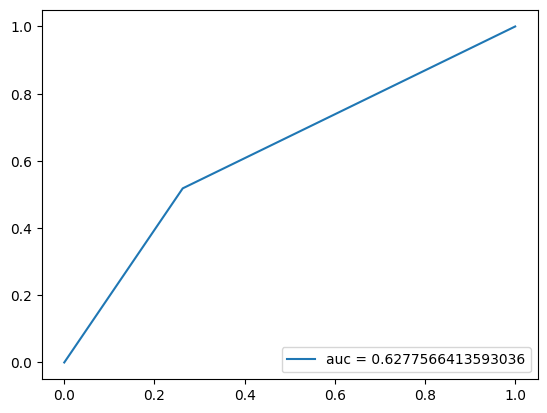

In [75]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 500 dataset

In [76]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 21488)

In [77]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5195615933033022,
 'f1': 0.47741039391951856,
 'precision': 0.5234791437515864,
 'recall': 0.43879432624113474,
 'roc_auc': 0.5207902645697552,
 'roc_curve': [[0.0,
   0.3709643085219613,
   0.3719577095011708,
   0.37209962392677215,
   0.3725963244163769,
   0.37280919605477897,
   0.37358972539558644,
   0.3742283403107926,
   0.37437025473639396,
   0.37444121194919466,
   0.37465408358759666,
   0.3749379124387994,
   0.37522174129000213,
   0.37529269850280284,
   0.3757893989924076,
   0.3760022706308096,
   0.376144185056411,
   0.37621514226921166,
   0.3764989711204144,
   0.3764989711204144,
   0.37664088554601577,
   0.377705243738026,
   0.3782729014404314,
   0.37855673029163417,
   0.3786986447172355,
   0.3801177889732491,
   0.3802597033988505,
   0.38068544667565457,
   0.3821755481444689,
   0.38281416305967503,
   0.38281416305967503,
   0.3830270346980771,
   0.38316894912367844,
   0.3904065848293479,
   0.39587029021500036,
   0.39956006528063576,


In [78]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 500 dataset

In [79]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': None}


(63, 17414)

In [80]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5511456338227991,
 'f1': 0.5389295733595657,
 'precision': 0.556173860730937,
 'recall': 0.5227224538836667,
 'roc_auc': 0.5512893380753849,
 'roc_curve': [[0.0, 0.42022071911712355, 0.42100391598433606, 1.0],
  [0.0, 0.5227224538836667, 0.5234998939854406, 1.0],
  [inf, 1.0, 0.5, 0.0]],
 'confusion_matrix': [[8143, 5902], [6753, 7396]],
 'brier_score_loss': 0.4486592892104703,
 'balanced_accuracy': 0.5512508673832716}

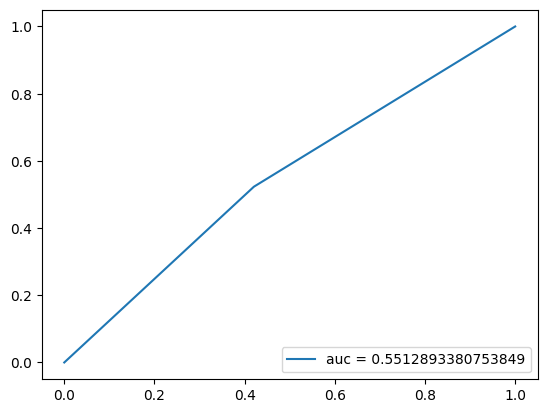

In [81]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Random 1k dataset

In [82]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 20941)

In [83]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.654468085106383,
 'f1': 0.6314535345512312,
 'precision': 0.6765134938001459,
 'recall': 0.5920212765957447,
 'roc_auc': 0.6371950788441225,
 'roc_curve': [[0.0,
   0.26085106382978723,
   0.2612056737588653,
   0.26166666666666666,
   0.2619858156028369,
   0.2631205673758865,
   0.26336879432624116,
   0.26390070921985814,
   0.26460992907801417,
   0.2650354609929078,
   0.2654964539007092,
   0.26585106382978724,
   0.26652482269503547,
   0.2675531914893617,
   0.26790780141843973,
   0.2704964539007092,
   0.2720567375886525,
   0.2725531914893617,
   0.27361702127659576,
   0.27393617021276595,
   0.2745035460992908,
   0.27574468085106385,
   0.27695035460992906,
   0.2772695035460993,
   0.2784751773049645,
   0.27907801418439715,
   0.27921985815602834,
   0.2796099290780142,
   0.28070921985815606,
   0.28304964539007094,
   0.28308510638297874,
   0.28308510638297874,
   0.2894326241134752,
   0.3129787234042553,
   0.32053191489361704,
   0.32897163120567374

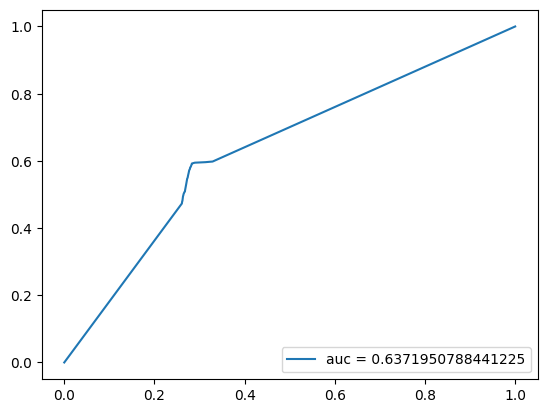

In [84]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 1k dataset

In [85]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 42834)

In [86]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5136184700500053,
 'f1': 0.47963423194399657,
 'precision': 0.5157276324915344,
 'recall': 0.4482624113475177,
 'roc_auc': 0.5144266762155019,
 'roc_curve': [[0.0,
   0.40327729304107257,
   0.40349010427750587,
   0.40363197843512805,
   0.4038093211321558,
   0.4040576009079946,
   0.40416400652621126,
   0.4042704121444279,
   0.40476697169610554,
   0.4048024402355111,
   0.4048024402355111,
   0.4050152514719444,
   0.4050152514719444,
   0.4053344683265943,
   0.4056891537206498,
   0.4058664964176775,
   0.4060793076541108,
   0.40629211889054406,
   0.40650493012697736,
   0.4068950840604384,
   0.40724976945449387,
   0.40739164361211605,
   0.40746258069092717,
   0.40746258069092717,
   0.40785273462438815,
   0.4078882031637937,
   0.40792367170319926,
   0.40838476271547136,
   0.4085621054124991,
   0.40916507058239343,
   0.4093778818188267,
   0.4096261615946655,
   0.4096261615946655,
   0.4097680357522877,
   0.4104064694615876,
   0.41058381215861534,


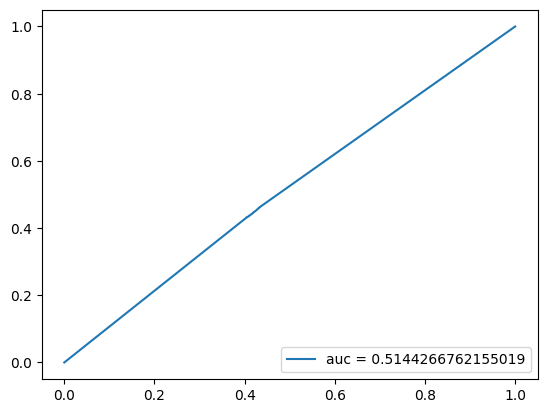

In [87]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 1k dataset

In [88]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 33993)

In [89]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5642621555484626,
 'f1': 0.5536320866105975,
 'precision': 0.5656014549233567,
 'recall': 0.5421588159954461,
 'roc_auc': 0.5628998425845277,
 'roc_curve': [[0.0,
   0.40472318461429685,
   0.4051474227533055,
   0.4057130736053171,
   0.40585448631832,
   0.40592519267482147,
   0.4068443753093403,
   0.40748073251785333,
   0.40786961747861133,
   0.40790497065686204,
   0.4082585024393693,
   0.41105140352117653,
   0.4118291734426925,
   0.41313724103796934,
   0.41317259421622005,
   0.41363218553347947,
   0.4136675387117302,
   0.41373824506823165,
   0.41377359824648235,
   0.41444530863324613,
   0.41444530863324613,
   0.41462207452449973,
   0.4151170190200099,
   0.4152230785547621,
   0.41964222583610267,
   1.0],
  [0.0,
   0.5264337555144443,
   0.5274299131919739,
   0.5282481855699445,
   0.5283904938095916,
   0.5287106873487974,
   0.5302405009250035,
   0.5317347374412978,
   0.5326597409990038,
   0.5327308951188274,
   0.5333001280774157,
   0.53831

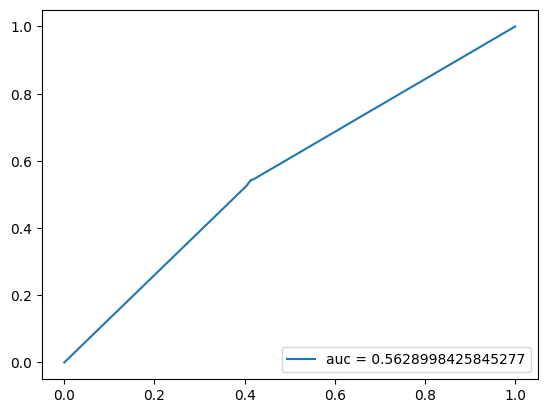

In [90]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

### 1-grams + 3-grams

In [91]:
n_grams = min_all_ngrams[0][1] + min_all_ngrams[2][1]
n_grams

[('\r',),
 ('\n',),
 ('def',),
 ('<SPACE1>',),
 ('<TAB4>',),
 ('<TAB2>',),
 ('<SINGLE_LEADING_UNDERSCORE_NAME>',),
 ('<LETTER_LOW>',),
 ('<SPACE4>',),
 ('(',),
 ('<SPACE2>',),
 (':',),
 ('<LOWERCASE>',),
 (')',),
 ('<TAB1>',),
 ('->',),
 ('<UPPER_CAMEL_CASE>',),
 ('=',),
 ('[',),
 (']',),
 ('{',),
 ("'''",),
 ('<STRING>',),
 (',',),
 ('}',),
 ('for',),
 ('in',),
 ('if',),
 ('<SNAKE_CASE>',),
 ('.',),
 ('elif',),
 ('and',),
 ('==',),
 ('<INT>',),
 ('or',),
 ('>',),
 ('!=',),
 ('return',),
 ('False',),
 ('else',),
 ('<MAGIC_NAME>',),
 ('"',),
 ('<UPPER_CAMEL_CASE2>',),
 ('<DOUBLE_TRAILING_UNDERSCORE_NAME>',),
 ('assert',),
 ('<COMMENT>',),
 ('*',),
 ('+',),
 ('<SCREAMING_SNAKE_CASE>',),
 ('-',),
 ('import',),
 ('from',),
 ('<UNDEF_NAME_PATTERN>',),
 ('raise',),
 ('F',),
 ('"""',),
 ('try',),
 ('not',),
 ('except',),
 ('pass',),
 ('True',),
 ('+=',),
 ('/',),
 ('f',),
 ('@',),
 ('None',),
 ('is',),
 ('<EXP_LOW>',),
 ('as',),
 ('<FLOAT>',),
 ('<NUMBER_UNDERSCORE>',),
 ('class',),
 ('<SINGL

#### Random 500 dataset

In [92]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 8447)

In [93]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.6437462321358913,
 'f1': 0.6038955918302974,
 'precision': 0.6799857929319837,
 'recall': 0.5431205673758865,
 'roc_auc': 0.6324892993265958,
 'roc_curve': [[0.0,
   0.22207248741045466,
   0.22427122490956805,
   0.22561883821547626,
   0.22703737853748493,
   0.22753386765018796,
   0.22888148095609617,
   0.23100929143910914,
   0.2320022696645152,
   0.2334917370026243,
   0.23420100716362863,
   0.23732179587204766,
   0.23796013901695157,
   0.24136463578977232,
   0.24186112490247536,
   0.24214483296687708,
   0.24214483296687708,
   0.24476913256259308,
   0.2449819136108944,
   0.245407475707497,
   0.2469678700617065,
   0.2515071990921342,
   0.25164905312433505,
   0.25342222852684587,
   0.25342222852684587,
   0.25505354989715584,
   0.25547911199375845,
   0.2556209660259593,
   0.2558337470742606,
   0.2558337470742606,
   0.2558337470742606,
   0.25618838215476275,
   0.2562593091708632,
   0.2563302361869636,
   0.25668487126746575,
   0.25781970352507

In [94]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 500 dataset

In [95]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 18219)

In [96]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5169722980881779,
 'f1': 0.4660026664575328,
 'precision': 0.5211366426942642,
 'recall': 0.42141843971631204,
 'roc_auc': 0.5189076590007714,
 'roc_curve': [[0.0,
   0.29411764705882354,
   0.29411764705882354,
   0.29440147591002624,
   0.294898176399631,
   0.2954658341020365,
   0.29603349180444194,
   0.2961044490172426,
   0.2961754062300433,
   0.29624636344284394,
   0.2965301922940467,
   0.2968140211452494,
   0.2968140211452494,
   0.29823316540126305,
   0.2983750798268644,
   0.2992975235932733,
   0.2996523096572767,
   0.29972326687007733,
   0.2999361385084794,
   0.30043283899808415,
   0.30050379621088485,
   0.30050379621088485,
   0.30206485489249985,
   0.30270346980770596,
   0.3027744270205066,
   0.3050450578301284,
   0.30539984389413183,
   0.30539984389413183,
   0.30618037323493935,
   0.30646420208614206,
   0.3074576030653516,
   0.30774143191655434,
   0.3085219612573618,
   0.3088767473213652,
   0.3093024905981693,
   0.30937344781097,
  

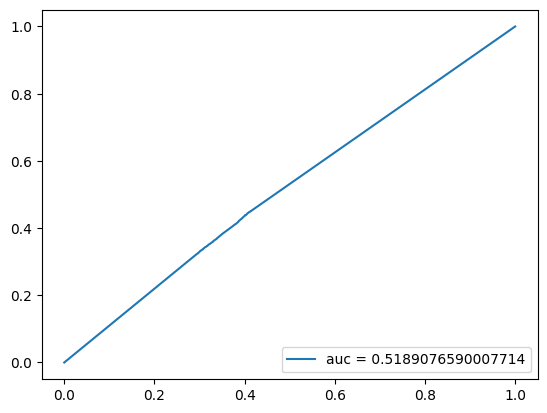

In [97]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 500 dataset

In [98]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 16587)

In [99]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5519968787685323,
 'f1': 0.5406073831605748,
 'precision': 0.5568709725760528,
 'recall': 0.5252668033076543,
 'roc_auc': 0.5506310564764101,
 'roc_curve': [[0.0,
   0.39793520825916695,
   0.3982200071199715,
   0.3994304022783909,
   0.40128159487362053,
   0.4017087931648273,
   0.4031327874688501,
   0.40320398718405126,
   0.4034175863296547,
   0.4046991812032752,
   0.40590957636169456,
   0.4065503737985048,
   0.4070487718049128,
   0.4080455678177287,
   0.408187967248131,
   0.4084015663937344,
   0.4091135635457458,
   0.4096119615521538,
   0.4099679601281595,
   0.4101103595585618,
   0.4101103595585618,
   0.41224635101459595,
   0.41224635101459595,
   0.4123175507297971,
   0.4143823424706301,
   0.4143823424706301,
   0.4143823424706301,
   0.41445354218583125,
   0.41459594161623353,
   0.4146671413314347,
   0.41480954076183696,
   0.41516553933784267,
   0.4152367390530438,
   0.4156639373442506,
   0.4169455322178711,
   0.41829832680669277,
   0.41

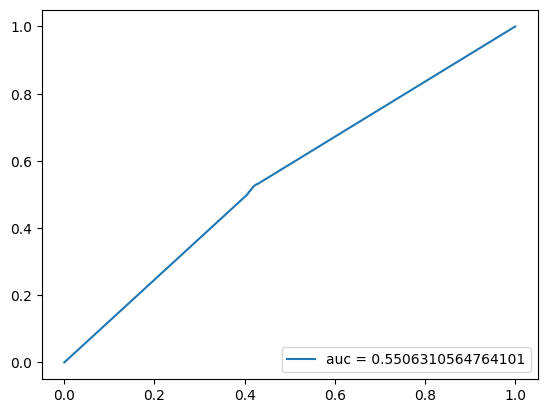

In [100]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Random 1k dataset

In [101]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 15963)

In [102]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.6523758865248227,
 'f1': 0.6291097574817449,
 'precision': 0.6742356662071203,
 'recall': 0.589645390070922,
 'roc_auc': 0.6409346134500277,
 'roc_curve': [[0.0,
   0.22035460992907802,
   0.22085106382978723,
   0.22234042553191488,
   0.2225177304964539,
   0.22326241134751773,
   0.22421985815602838,
   0.22528368794326242,
   0.22542553191489362,
   0.22613475177304965,
   0.22695035460992907,
   0.2276950354609929,
   0.22858156028368795,
   0.22939716312056738,
   0.22957446808510637,
   0.23095744680851063,
   0.2323404255319149,
   0.2326950354609929,
   0.23312056737588652,
   0.23351063829787233,
   0.2346808510638298,
   0.235177304964539,
   0.23578014184397164,
   0.23624113475177305,
   0.23680851063829786,
   0.23687943262411348,
   0.2374468085106383,
   0.2378014184397163,
   0.23929078014184396,
   0.24049645390070923,
   0.24351063829787234,
   0.24375886524822696,
   0.2478723404255319,
   0.2479787234042553,
   0.25109929078014187,
   0.2524113475177

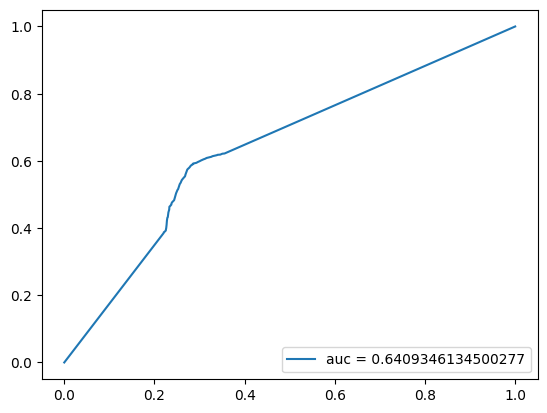

In [103]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 1k dataset

In [104]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 37785)

In [105]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.518104762918041,
 'f1': 0.4980977357514868,
 'precision': 0.5197332922223079,
 'recall': 0.47819148936170214,
 'roc_auc': 0.5171652518241142,
 'roc_curve': [[0.0,
   0.34429311200964746,
   0.3444704547066752,
   0.344718734482514,
   0.3452507625735972,
   0.3455345108888416,
   0.34574732212527487,
   0.3461374760587359,
   0.346598567071008,
   0.3468823153862524,
   0.34744981201674113,
   0.3483365255018798,
   0.3492587075264241,
   0.34929417606582963,
   0.35000354685394053,
   0.35000354685394053,
   0.35028729516918494,
   0.3504646378662127,
   0.35074838618145704,
   0.3509966659572959,
   0.3511385401149181,
   0.35159963112719017,
   0.3518833794424346,
   0.35216712775767894,
   0.3528764985457899,
   0.35358586933390085,
   0.35372774349152303,
   0.35397602326736183,
   0.3551110165283394,
   0.3552883592253671,
   0.35613960417110024,
   0.3565652266439668,
   0.3572391288926722,
   0.35801943675959425,
   0.35801943675959425,
   0.35890615024473294,
  

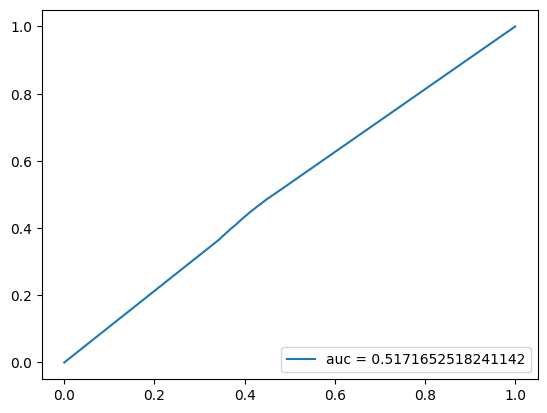

In [106]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 1k dataset

In [107]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 31302)

In [108]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5598467922119374,
 'f1': 0.5539302016317436,
 'precision': 0.5596630111119181,
 'recall': 0.5483136473601822,
 'roc_auc': 0.5555703066598173,
 'roc_curve': [[0.0,
   0.3828395672770982,
   0.38404157533762284,
   0.38460722618963444,
   0.38513752386339534,
   0.3854557024676518,
   0.3856678215371562,
   0.38676377006292867,
   0.38704659548893444,
   0.3871526550236866,
   0.38743548044969245,
   0.38789507176695187,
   0.3881071908364562,
   0.38877890122321995,
   0.3895920243229866,
   0.3895920243229866,
   0.389804143392491,
   0.38991020292724315,
   0.38994555610549386,
   0.3899809092837446,
   0.39044050060100405,
   0.39188998090928373,
   0.3924202785830446,
   0.39245563176129533,
   0.392632397652549,
   0.392632397652549,
   0.3930919889698084,
   0.3937636993565722,
   0.39418793749558084,
   0.395071766951849,
   0.3951424733083504,
   0.3954252987343562,
   0.3958141836951142,
   0.3961323622993707,
   0.39641518772537654,
   0.3969454853991374,
   0.3

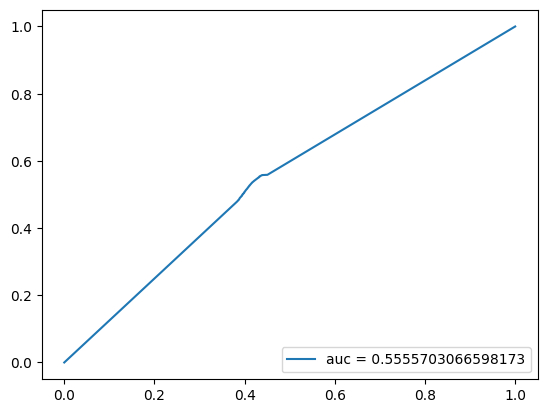

In [109]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

### 2-grams + 3-grams

In [110]:
n_grams = min_all_ngrams[1][1] + min_all_ngrams[2][1]
n_grams

[('\r', '\n'),
 ('\n', '\r'),
 ('\n', 'def'),
 ('def', '<SPACE1>'),
 ('<SPACE1>', '<TAB4>'),
 ('<TAB4>', '<TAB2>'),
 ('<TAB2>', '<SINGLE_LEADING_UNDERSCORE_NAME>'),
 ('<SINGLE_LEADING_UNDERSCORE_NAME>', '<LETTER_LOW>'),
 ('<LETTER_LOW>', '<SPACE4>'),
 ('<SPACE4>', '('),
 ('(', '<SPACE4>'),
 ('<SPACE4>', '<SPACE2>'),
 ('<SPACE2>', '<LETTER_LOW>'),
 ('<LETTER_LOW>', '<SPACE1>'),
 ('<SPACE1>', ':'),
 (':', '<LOWERCASE>'),
 ('<LOWERCASE>', '<SPACE1>'),
 ('<SPACE1>', ')'),
 (')', '<TAB4>'),
 ('<TAB2>', '<TAB1>'),
 ('<TAB1>', '->'),
 ('->', '<TAB2>'),
 ('<TAB1>', '<UPPER_CAMEL_CASE>'),
 ('<UPPER_CAMEL_CASE>', ':'),
 (':', '\r'),
 ('\n', '<SPACE1>'),
 ('<SPACE1>', '<LETTER_LOW>'),
 ('<LETTER_LOW>', '<TAB2>'),
 ('<TAB2>', '<SPACE2>'),
 ('<SPACE2>', '='),
 ('=', '<SPACE4>'),
 ('<SPACE2>', '['),
 ('[', ']'),
 (']', '\r'),
 ('<SPACE2>', '<LOWERCASE>'),
 ('<LOWERCASE>', '('),
 ('{', "'''"),
 ("'''", '<STRING>'),
 ('<STRING>', "'''"),
 ("'''", ','),
 (',', '<SPACE1>'),
 ('<SPACE1>', "'''"),
 (')', 

#### Random 500 dataset

In [111]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 5662)

In [112]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.705769708145679,
 'f1': 0.6725083876060786,
 'precision': 0.7582554517133956,
 'recall': 0.6041843971631206,
 'roc_auc': 0.7054981365309847,
 'roc_curve': [[0.0,
   0.12483154833676147,
   0.12497340236896234,
   0.12610823462656925,
   0.12653379672317186,
   0.12660472373927228,
   0.12752677494857792,
   0.12908716930278744,
   0.13362649833321513,
   0.1351159656713242,
   0.13518689268742465,
   0.13766933825093977,
   0.13781119228314065,
   0.14022271083055535,
   0.14064827292715795,
   0.14086105397545925,
   0.1431307184906731,
   0.14355628058727568,
   0.14632243421519256,
   0.1472444854244982,
   0.14788282856940207,
   0.1498687850202142,
   0.15100361727782113,
   0.15625221646925314,
   0.15667777856585574,
   0.15674870558195617,
   0.15795446485566353,
   0.15823817292006526,
   0.15823817292006526,
   0.15852188098446698,
   0.16185545074118732,
   0.16192637775728774,
   0.16192637775728774,
   0.16327399106319598,
   0.16341584509539683,
   0.163415

In [113]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 500 dataset

In [114]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 16045)

In [115]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5272940091512077,
 'f1': 0.49866456005717935,
 'precision': 0.5309621084675158,
 'recall': 0.4700709219858156,
 'roc_auc': 0.5300757656962639,
 'roc_curve': [[0.0,
   0.28688001135315405,
   0.2877314979067622,
   0.2878024551195629,
   0.2878734123323636,
   0.28801532675796493,
   0.28844107003476904,
   0.2886539416731711,
   0.28907968494997516,
   0.28936351380117786,
   0.2901440431419854,
   0.29035691478038744,
   0.2904278719931881,
   0.29092457248279285,
   0.2911374441211949,
   0.29127935854679626,
   0.29142127297239767,
   0.2916341446107997,
   0.29184701624920173,
   0.2924146739516072,
   0.293337117718016,
   0.2938338182076208,
   0.29411764705882354,
   0.2941886042716242,
   0.2946143475484283,
   0.2956077485276378,
   0.29596253459164124,
   0.2961754062300433,
   0.29624636344284394,
   0.29631732065564464,
   0.296459235081246,
   0.2990846519548712,
   0.2990846519548712,
   0.299581352444476,
   0.2996523096572767,
   0.2996523096572767,
   0.

In [116]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 500 dataset

In [117]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 15230)

In [118]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5541604596722707,
 'f1': 0.5393579595426561,
 'precision': 0.5600882867798158,
 'recall': 0.5201074280867906,
 'roc_auc': 0.5526770380868156,
 'roc_curve': [[0.0,
   0.37415450338198647,
   0.37443930224279104,
   0.3750088999644001,
   0.37607689569241726,
   0.37742969028123885,
   0.3786400854396582,
   0.3787824848700605,
   0.38177287290850836,
   0.38227127091491636,
   0.38241367034531865,
   0.38319686721253116,
   0.3834104663581346,
   0.38412246351014595,
   0.3848344606621574,
   0.3851192595229619,
   0.38554645781416874,
   0.385688857244571,
   0.38632965468138125,
   0.3878248487006052,
   0.39045923816304734,
   0.39067283730865077,
   0.3921680313278747,
   0.39366322534709863,
   0.39508721965112137,
   0.39522961908152365,
   0.39651121395514416,
   0.3976504093983624,
   0.3982200071199715,
   0.3988608045567818,
   0.40142399430402276,
   0.4018511925952296,
   0.4022071911712353,
   0.4022071911712353,
   0.4039159843360627,
   0.40768956924172306,

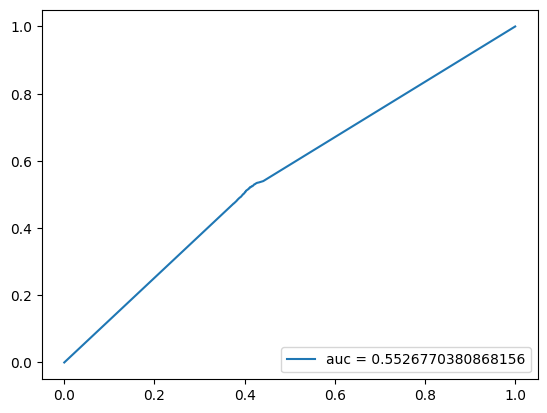

In [119]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Random 1k dataset

In [120]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 13710)

In [121]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.6717553191489362,
 'f1': 0.6491956113921892,
 'precision': 0.6971065803931144,
 'recall': 0.6074468085106383,
 'roc_auc': 0.6590972272521503,
 'roc_curve': [[0.0,
   0.19148936170212766,
   0.19152482269503546,
   0.1922340425531915,
   0.1925531914893617,
   0.19276595744680852,
   0.19687943262411348,
   0.1973404255319149,
   0.19819148936170214,
   0.19897163120567377,
   0.19907801418439716,
   0.20039007092198582,
   0.20120567375886525,
   0.20209219858156027,
   0.2022695035460993,
   0.2024468085106383,
   0.20382978723404255,
   0.2047517730496454,
   0.20666666666666667,
   0.20847517730496454,
   0.20886524822695035,
   0.2100709219858156,
   0.210177304964539,
   0.210354609929078,
   0.21145390070921985,
   0.21166666666666667,
   0.21166666666666667,
   0.21308510638297873,
   0.2147872340425532,
   0.2148581560283688,
   0.21578014184397162,
   0.21599290780141844,
   0.21783687943262411,
   0.2178723404255319,
   0.21925531914893617,
   0.221099290780141

In [122]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 1k dataset

In [123]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 33054)

In [124]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5267581657623152,
 'f1': 0.5208273484630854,
 'precision': 0.5274949083503055,
 'recall': 0.5143262411347518,
 'roc_auc': 0.5285628814440173,
 'roc_curve': [[0.0,
   0.3129034546357381,
   0.31428672767255444,
   0.31439313329077107,
   0.31549265801234305,
   0.31556359509115417,
   0.31584734340639853,
   0.31595374902461515,
   0.316202028800454,
   0.3169468681279705,
   0.3172306164432149,
   0.3175498332978648,
   0.31783358161310915,
   0.3182237355465702,
   0.31836560970419236,
   0.3185429524012201,
   0.3195006029651699,
   0.31971341420160315,
   0.31978435128041427,
   0.3198907568986309,
   0.32006809959565863,
   0.3206355962261474,
   0.320742001844364,
   0.3210966872384195,
   0.32127402993544724,
   0.3215932467900972,
   0.32177058948712495,
   0.32208980634177486,
   0.32255089735404696,
   0.32297651982691356,
   0.32315386252394124,
   0.3236149535362134,
   0.32365042207561895,
   0.32375682769383557,
   0.3238632333120522,
   0.32404057600907993,

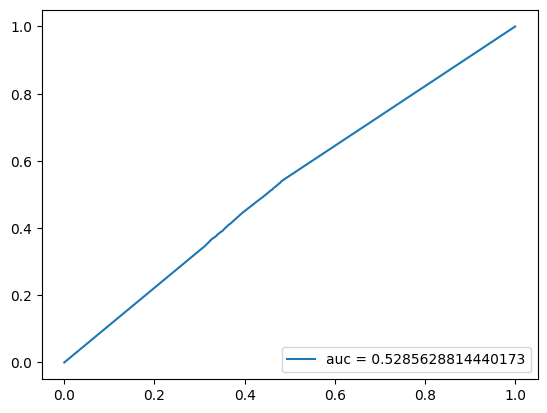

In [125]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 1k dataset

In [126]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 28155)

In [127]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5726850374153278,
 'f1': 0.5606082707315295,
 'precision': 0.5749925194494315,
 'recall': 0.5469261420236232,
 'roc_auc': 0.573115299905685,
 'roc_curve': [[0.0,
   0.336244078342643,
   0.336632963303401,
   0.337269320511914,
   0.3377642650074242,
   0.3380824436116807,
   0.33843597539418796,
   0.3385066817506894,
   0.33931980485045604,
   0.3396733366329633,
   0.33988545570246764,
   0.3412288764759952,
   0.3420773527540126,
   0.3425015908930213,
   0.34260765042777347,
   0.343951071201301,
   0.34444601569681116,
   0.3447995474793184,
   0.344976313370572,
   0.346390440500601,
   0.3465318532136039,
   0.3466379127483561,
   0.34706215088736475,
   0.34745103584812276,
   0.34748638902637347,
   0.34748638902637347,
   0.34890051615640244,
   0.34932475429541116,
   0.34974899243441987,
   0.3497843456126706,
   0.35024393692993,
   0.35024393692993,
   0.3503499964646822,
   0.3512338259209503,
   0.3515166513469561,
   0.35158735770345756,
   0.3527893657

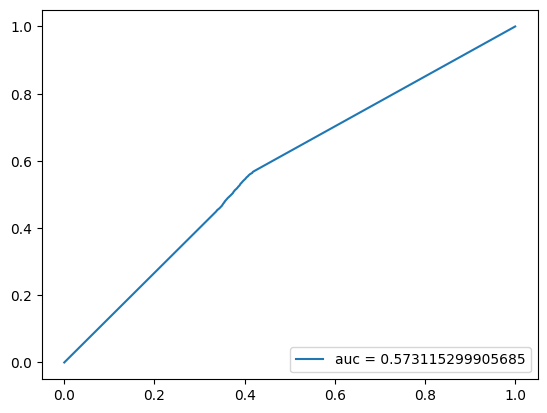

In [128]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

### 1-grams + 2-grams + 3-grams

In [129]:
n_grams = min_all_ngrams[0][1] + min_all_ngrams[1][1] + min_all_ngrams[2][1]
n_grams

[('\r',),
 ('\n',),
 ('def',),
 ('<SPACE1>',),
 ('<TAB4>',),
 ('<TAB2>',),
 ('<SINGLE_LEADING_UNDERSCORE_NAME>',),
 ('<LETTER_LOW>',),
 ('<SPACE4>',),
 ('(',),
 ('<SPACE2>',),
 (':',),
 ('<LOWERCASE>',),
 (')',),
 ('<TAB1>',),
 ('->',),
 ('<UPPER_CAMEL_CASE>',),
 ('=',),
 ('[',),
 (']',),
 ('{',),
 ("'''",),
 ('<STRING>',),
 (',',),
 ('}',),
 ('for',),
 ('in',),
 ('if',),
 ('<SNAKE_CASE>',),
 ('.',),
 ('elif',),
 ('and',),
 ('==',),
 ('<INT>',),
 ('or',),
 ('>',),
 ('!=',),
 ('return',),
 ('False',),
 ('else',),
 ('<MAGIC_NAME>',),
 ('"',),
 ('<UPPER_CAMEL_CASE2>',),
 ('<DOUBLE_TRAILING_UNDERSCORE_NAME>',),
 ('assert',),
 ('<COMMENT>',),
 ('*',),
 ('+',),
 ('<SCREAMING_SNAKE_CASE>',),
 ('-',),
 ('import',),
 ('from',),
 ('<UNDEF_NAME_PATTERN>',),
 ('raise',),
 ('F',),
 ('"""',),
 ('try',),
 ('not',),
 ('except',),
 ('pass',),
 ('True',),
 ('+=',),
 ('/',),
 ('f',),
 ('@',),
 ('None',),
 ('is',),
 ('<EXP_LOW>',),
 ('as',),
 ('<FLOAT>',),
 ('<NUMBER_UNDERSCORE>',),
 ('class',),
 ('<SINGL

#### Random 500 dataset

In [130]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 100}


(100, 8984)

In [131]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.639419837582893,
 'f1': 0.5908249496981891,
 'precision': 0.6828837209302325,
 'recall': 0.5206382978723404,
 'roc_auc': 0.6377239621139068,
 'roc_curve': [[0.0,
   0.23271153982551954,
   0.23491027732463296,
   0.2365415986949429,
   0.24171927087027448,
   0.24179019788637493,
   0.24179019788637493,
   1.0],
  [0.0,
   0.4868794326241135,
   0.4951063829787234,
   0.506241134751773,
   0.5204964539007092,
   0.5205673758865248,
   0.5206382978723404,
   1.0],
  [inf,
   1.0,
   0.9987080103359173,
   0.9978712080894092,
   0.9915693904020753,
   0.8780487804878049,
   0.8571428571428571,
   0.0]],
 'confusion_matrix': [[10690, 3409], [6759, 7341]],
 'brier_score_loss': 0.3605240571945237,
 'balanced_accuracy': 0.6394240499929827}

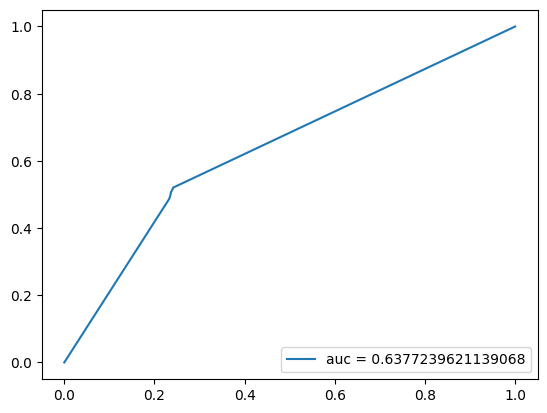

In [132]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 500 dataset

In [133]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 17494)

In [134]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5238534387968645,
 'f1': 0.4709128172788901,
 'precision': 0.5299858055358411,
 'recall': 0.4236879432624113,
 'roc_auc': 0.5244100939403045,
 'roc_curve': [[0.0,
   0.30681898815014547,
   0.3080962179805577,
   0.3085929184701625,
   0.30866387568296316,
   0.3088057901085645,
   0.3088767473213652,
   0.3090896189597673,
   0.31057972042858156,
   0.31143120698218973,
   0.3115731214077911,
   0.3116440786205918,
   0.31242460796139926,
   0.312708436812602,
   0.31277939402540267,
   0.3128503512382034,
   0.3128503512382034,
   0.312921308451004,
   0.312921308451004,
   0.3132051373022068,
   0.31334705172780813,
   0.31398566664301425,
   0.3141275810686156,
   0.314269495494217,
   0.31434045270701766,
   0.3147661959838218,
   0.3149081104094231,
   0.3150500248350245,
   0.31554672532462924,
   0.3156886397502306,
   0.3168239551550415,
   0.3168949123678422,
   0.31781735613425105,
   0.3179592705598524,
   0.3180302277726531,
   0.3186688426878592,
   0.31873

In [135]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 500 dataset

In [136]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-500", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 15650)

In [137]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5495495495495496,
 'f1': 0.5370707880731939,
 'precision': 0.5545351900639819,
 'recall': 0.5206728390698989,
 'roc_auc': 0.5495917162560765,
 'roc_curve': [[0.0,
   0.4005695977216091,
   0.4010679957280171,
   0.40142399430402276,
   0.4037735849056604,
   0.4049127803488786,
   0.4061943752224991,
   0.40626557493770027,
   0.40640797436810255,
   0.40683517265930935,
   0.40697757208971164,
   0.4070487718049128,
   0.40719117123531506,
   0.40776076895692415,
   0.4080455678177287,
   0.4080455678177287,
   0.4080455678177287,
   0.4083303666785333,
   0.4085439658241367,
   0.4085439658241367,
   0.4088999644001424,
   0.41082235671057316,
   0.4108935564257743,
   0.4125311498754005,
   0.41573513705945175,
   0.4159487362050552,
   0.4185119259522962,
   0.42079031683873264,
   0.4209327162691349,
   0.4209327162691349,
   0.4213599145603418,
   0.4217871128515486,
   0.42385190459238165,
   0.42385190459238165,
   0.42385190459238165,
   0.42399430402278393,
   

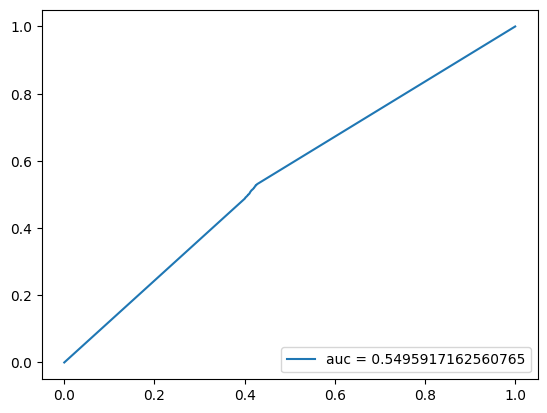

In [138]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Random 1k dataset

In [139]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-random-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 15601)

In [140]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.6580851063829787,
 'f1': 0.63405192044937,
 'precision': 0.6819888961463096,
 'recall': 0.5924113475177305,
 'roc_auc': 0.6430946098033299,
 'roc_curve': [[0.0,
   0.2246099290780142,
   0.22574468085106383,
   0.22627659574468084,
   0.22659574468085106,
   0.2272340425531915,
   0.22741134751773048,
   0.2296099290780142,
   0.23106382978723405,
   0.23159574468085106,
   0.2325886524822695,
   0.23304964539007092,
   0.23336879432624114,
   0.23425531914893616,
   0.2349645390070922,
   0.23851063829787233,
   0.23950354609929078,
   0.2397872340425532,
   0.24297872340425533,
   0.24716312056737588,
   0.24723404255319148,
   0.2473049645390071,
   0.2473049645390071,
   0.24858156028368794,
   0.2518794326241135,
   0.255177304964539,
   0.25549645390070924,
   0.2569503546099291,
   0.25762411347517733,
   0.259113475177305,
   0.2591489361702128,
   0.2601418439716312,
   0.26060283687943264,
   0.26191489361702125,
   0.2620567375886525,
   0.26336879432624116,
 

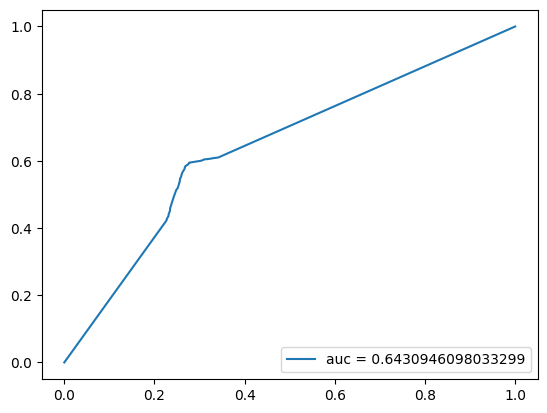

In [141]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Single 1k dataset

In [142]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-single-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 37267)

In [143]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.5215625775791751,
 'f1': 0.4846331633335244,
 'precision': 0.5252349604603983,
 'recall': 0.4498581560283688,
 'roc_auc': 0.5224175318726333,
 'roc_curve': [[0.0,
   0.3357806625523161,
   0.33606441086756045,
   0.336099879406966,
   0.33627722210399374,
   0.3363836277222104,
   0.3366319074980492,
   0.33670284457686034,
   0.33680925019507696,
   0.33691565581329364,
   0.33748315244378235,
   0.33780236929843227,
   0.33797971199546,
   0.33801518053486557,
   0.3380861176136767,
   0.33844080300773216,
   0.339079236717032,
   0.3391501737958431,
   0.3393984535716819,
   0.3400723558203873,
   0.3402142299780095,
   0.3404979782932539,
   0.34056891537206496,
   0.34092360076612044,
   0.3413137546995815,
   0.34156203447542033,
   0.34188125133007025,
   0.3421649996453146,
   0.3422359367241257,
   0.3424842164999645,
   0.3425906221181812,
   0.34347733560331983,
   0.34347733560331983,
   0.34376108391856425,
   0.3439029580761864,
   0.34397389515499754,
   0

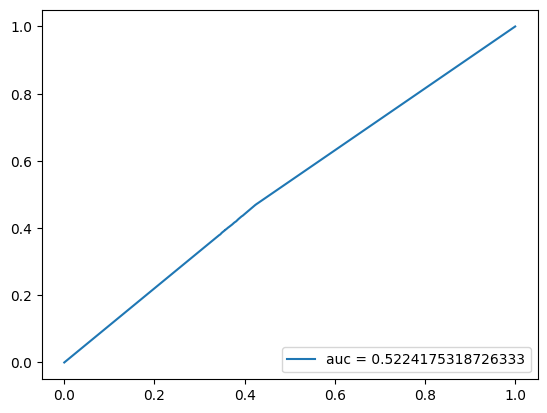

In [144]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])

#### Mixed 1k dataset

In [145]:
dataset = preprocess_dataset("infinityofspace/python_codestyles-mixed1-1k", n_grams)
clear_output()
X_train, y_train, X_test, y_test = get_stacked_train_test_dataset(dataset)
model, best_params = find_best_model_params(dataset, params, X_train, y_train, X_test, y_test)
print(best_params)
model.get_depth(), model.get_n_leaves()

{'max_depth': 50}


(50, 30294)

In [146]:
evals = eval_clf(model, X_test, y_test)
evals

{'accuracy': 0.555626485087066,
 'f1': 0.5447443955964103,
 'precision': 0.5565743559284282,
 'recall': 0.533406859257151,
 'roc_auc': 0.5540858027069677,
 'roc_curve': [[0.0,
   0.3925263381177968,
   0.3931273421480591,
   0.39330410803931276,
   0.39358693346531853,
   0.3937283461783214,
   0.39489500106059533,
   0.3952485328431026,
   0.39609700912112,
   0.39715760446864173,
   0.3972283108251432,
   0.397511136251149,
   0.39765254896415186,
   0.39775860849890404,
   0.39892526338117795,
   0.399172735628933,
   0.39942020787668814,
   0.40016262461995333,
   0.40072827547196493,
   0.4015767517499823,
   0.40260199391925333,
   0.4028141129887577,
   0.4028494661670084,
   0.40348582337552147,
   0.4041221805840345,
   0.4041221805840345,
   0.40419288694053596,
   0.4056777204270664,
   0.4061373117443258,
   0.406243371279078,
   0.40645549034858236,
   0.4069504348440925,
   0.40702114120059396,
   0.40723326027009826,
   0.40829385561762005,
   0.4083999151523722,
   0.40

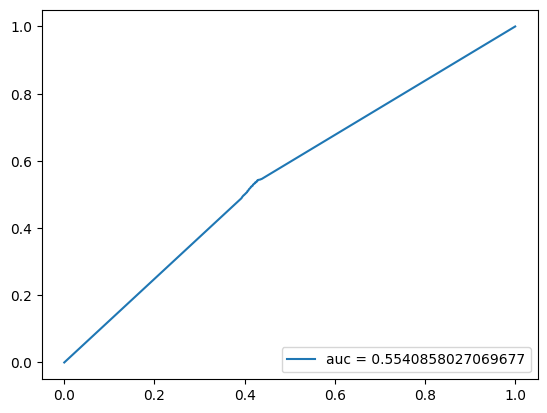

In [147]:
plot_roc_curve(evals["roc_curve"][0], evals["roc_curve"][1], evals["roc_auc"])